In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer  # Use BERT Model and Tokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Attention Layer in PyTorch
class CustomAttention(nn.Module):
    def __init__(self, input_dim):
        super(CustomAttention, self).__init__()
        self.W = nn.Parameter(torch.randn(input_dim, 1))
        self.b = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        e = F.relu(torch.matmul(x, self.W) + self.b)
        a = torch.softmax(e, dim=1)
        output = torch.sum(x * a, dim=1)
        return output

# Define the PyTorch Model (using BERT)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # Using BERT base model
        self.cnn = nn.Conv1d(in_channels=768, out_channels=64, kernel_size=3, padding=1)
        self.attention = CustomAttention(input_dim=768)
        self.fc1 = nn.Linear(768 + 64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)[0]
        cnn_output = self.cnn(bert_output.transpose(1, 2))
        cnn_output = F.max_pool1d(cnn_output, kernel_size=cnn_output.shape[2]).squeeze(2)
        attention_output = self.attention(bert_output)
        combined = torch.cat((cnn_output, attention_output), 1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x




In [2]:

# Data Preparation
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          tweet,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'tweet_text': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.float)
        }



In [4]:
# Function to preprocess text data
def preprocess_text(text):
    # Implement text cleaning here (e.g., removing URLs, non-alphanumeric characters, etc.)
    return text

# Load and preprocess data
df_train = pd.read_csv("/Users/aaadfg/Downloads/my_code/ICWSM/Dataset/train_data2.csv")
df_test = pd.read_csv("/Users/aaadfg/Downloads/my_code/ICWSM/Dataset/test_data2.csv")

# Assuming preprocess_text function is defined
df_train['tweet'] = df_train['no_stop_joined'].apply(preprocess_text)
df_test['tweet'] = df_test['no_stop_joined'].apply(preprocess_text)

# Encode labels as binary
encoded_dict = {"Relevant": 0, "Not Relevant": 1}
df_train['event'] = df_train['Relevance'].map(encoded_dict)
df_test['event'] = df_test['Relevance'].map(encoded_dict)

# Create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
train_dataset = TweetDataset(
    tweets=df_train.tweet.to_numpy(),
    labels=df_train.event.to_numpy(),
    tokenizer=tokenizer,
    max_len=100
)
test_dataset = TweetDataset(
    tweets=df_test.tweet.to_numpy(),
    labels=df_test.event.to_numpy(),
    tokenizer=tokenizer,
    max_len=100
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [5]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model Initialization and transfer to device
model = MyModel().to(device)

# Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()

Using device: cuda


In [6]:
from sklearn.metrics import accuracy_score

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Aggregate loss
        total_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()  # Convert to binary predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy over the epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

Epoch 1/10 - Loss: 0.3325, Accuracy: 0.8535
Epoch 2/10 - Loss: 0.1998, Accuracy: 0.9186
Epoch 3/10 - Loss: 0.1279, Accuracy: 0.9515
Epoch 4/10 - Loss: 0.0742, Accuracy: 0.9725
Epoch 5/10 - Loss: 0.0524, Accuracy: 0.9815
Epoch 6/10 - Loss: 0.0455, Accuracy: 0.9836
Epoch 7/10 - Loss: 0.0288, Accuracy: 0.9899
Epoch 8/10 - Loss: 0.0258, Accuracy: 0.9910
Epoch 9/10 - Loss: 0.0237, Accuracy: 0.9916
Epoch 10/10 - Loss: 0.0250, Accuracy: 0.9908


In [7]:
# # Evaluation
# model.eval()
# predictions, true_labels = [], []
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids, attention_mask)
#         predictions.extend(outputs.cpu().tolist())
#         true_labels.extend(labels.cpu().tolist())

# # Convert predictions to binary
# binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

# # Classification report and confusion matrix
# print(classification_report(true_labels, binary_predictions))
# cm = confusion_matrix(true_labels, binary_predictions)

# # # Plot confusion matrix
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# # plt.title('Confusion Matrix')
# # plt.ylabel('Actual Label')
# # plt.xlabel('Predicted Label')
# # plt.xticks([0.5, 1.5], ['Not Relevant', 'Relevant'])
# # plt.yticks([0.5, 1.5], ['Not Relevant', 'Relevant'], va='center')
# # plt.show()

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')  # Changed to YlGnBu colormap
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Label')
# plt.xlabel('Predicted Label')
# plt.xticks([0.5, 1.5], ['Not Relevant', 'Relevant'])
# plt.yticks([0.5, 1.5], ['Not Relevant', 'Relevant'], va='center')
# plt.show()


In [8]:
# # Evaluation
# model.eval()
# predictions, true_labels = [], []
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids, attention_mask)
#         predictions.extend(outputs.cpu().tolist())
#         true_labels.extend(labels.cpu().tolist())

# # Convert predictions to binary
# binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch

# Ensure the model is in evaluation mode
model.eval()

predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Convert predictions to binary
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

In [9]:


# Assuming predictions are single probability values for the positive class
auc_roc = roc_auc_score(true_labels, predictions)
print(f'AUC-ROC: {auc_roc}')

# Classification report and confusion matrix
print(classification_report(true_labels, binary_predictions))
print(f'AUC-ROC: {auc_roc}')

AUC-ROC: 0.9487127327897849
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      3808
         1.0       0.84      0.76      0.80      1411

    accuracy                           0.90      5219
   macro avg       0.88      0.85      0.86      5219
weighted avg       0.89      0.90      0.89      5219

AUC-ROC: 0.9487127327897849


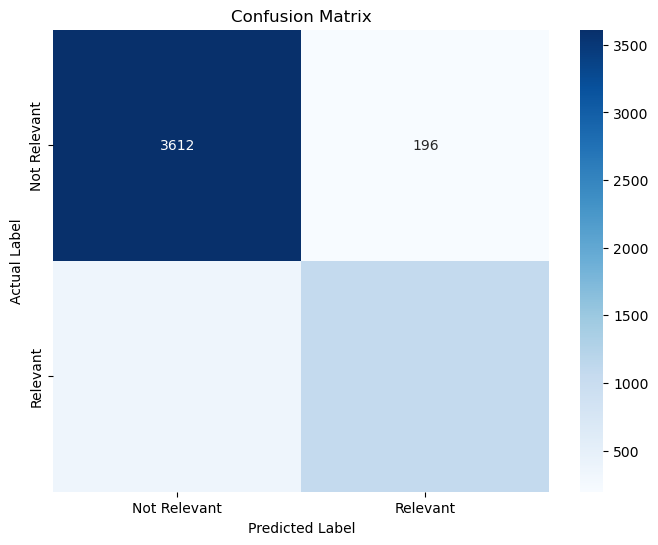

In [10]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Not Relevant', 'Relevant'])
plt.yticks([0.5, 1.5], ['Not Relevant', 'Relevant'], va='center')
plt.show()
